In [1]:
import pandas as pd
import numpy as np
import sqlite3
import itertools

pd.set_option('display.max_columns', 1000)

In [2]:
conn = sqlite3.connect('./database/database.sqlite')

# 1. EDA

In [3]:
pd.read_sql('SELECT * FROM sqlite_master where type="table"', conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
matches_df = pd.read_sql('SELECT * FROM Match', conn)
players_df = pd.read_sql('SELECT * FROM Player', conn)
leagues_df = pd.read_sql('SELECT * FROM League', conn)
country_df = pd.read_sql('SELECT * FROM Country', conn)
team_df = pd.read_sql('SELECT * FROM Team', conn)
team_attributes_df = pd.read_sql('SELECT * FROM Team_Attributes', conn)
player_attributes_df = pd.read_sql('SELECT * FROM Player_Attributes', conn)

## How many total matches are there?

In [5]:
matches_df.shape

(25979, 115)

### What are the earliest matches we have?

In [6]:
matches_df.sort_values(by='date', ascending=True).iloc[0:5, :]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
24558,24559,24558,24558,2008/2009,1,2008-07-18 00:00:00,486263,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24559,24560,24558,24558,2008/2009,1,2008-07-19 00:00:00,486264,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24560,24561,24558,24558,2008/2009,1,2008-07-20 00:00:00,486265,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24561,24562,24558,24558,2008/2009,1,2008-07-20 00:00:00,486266,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24613,24614,24558,24558,2008/2009,2,2008-07-23 00:00:00,486268,6493,7955,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Is there enough player data per match? Print a dataframe showing the number of missing rows per column

In [7]:
# matches_df = matches_df.dropna(subset=[f'home_player_{i}' for i in range(1, 12)], axis=0)
# matches_df = matches_df.dropna(subset=[f'away_player_{i}' for i in range(1, 12)], axis=0)
# for col in matches_df.columns:
#     if f'home_player_' in col:
#         matches_df[col] = matches_df[col].fillna(matches_df[col].mean())

matches_df = matches_df.iloc[:, :-30] # remove betting features

dic = dict(zip(matches_df.columns, matches_df.isna().sum()))
na_df = pd.DataFrame([dic])
na_df

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,0,0,0,0,0,0,0,0,0,0,0,1821,1821,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1833,1833,1839,1821,1821,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1832,1833,1833,1839,1224,1315,1281,1323,1316,1325,1227,1309,1273,1436,1555,1234,1278,1293,1321,1335,1313,1235,1341,1328,1441,1554,11762,11762,11762,11762,11762,11762,11762,11762


In [8]:
# merge matches dataframe with team attributes frame by team ID and season
def get_season(date):
    year, month = date.split('-')[0], date.split('-')[1]
    # typical season runs from august to may
    if (int(month) < 8):
        return f'{int(year)-1}/{year}'
    return f'{year}/{int(year)+1}'

team_attributes_df['season_new'] = team_attributes_df['date'].apply(get_season)
# There are duplicate seasons for some players
matches_df = matches_df.merge(team_attributes_df, left_on=['home_team_api_id','season'], right_on = ['team_api_id','season_new'], how='left')
matches_df = matches_df.merge(team_attributes_df, left_on=['away_team_api_id','season'], right_on = ['team_api_id','season_new'], how='left')
# matches_df = matches_df.drop(['home_team_api_id', 'team_api_id', 'match_id', 'date', 'match_api_id', 'away_team_api_id'])
matches_df.head()

,id_x,country_id,league_id,season,stage,date_x,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,id_y,team_fifa_api_id_x,team_api_id_x,date_y,buildUpPlaySpeed_x,buildUpPlaySpeedClass_x,buildUpPlayDribbling_x,buildUpPlayDribblingClass_x,buildUpPlayPassing_x,buildUpPlayPassingClass_x,buildUpPlayPositioningClass_x,chanceCreationPassing_x,chanceCreationPassingClass_x,chanceCreationCrossing_x,chanceCreationCrossingClass_x,chanceCreationShooting_x,chanceCreationShootingClass_x,chanceCreationPositioningClass_x,defencePressure_x,defencePressureClass_x,defenceAggression_x,defenceAggressionClass_x,defenceTeamWidth_x,defenceTeamWidthClass_x,defenceDefenderLineClass_x,season_new_x,id,team_fifa_api_id_y,team_api_id_y,date,buildUpPlaySpeed_y,buildUpPlaySpeedClass_y,buildUpPlayDribbling_y,buildUpPlayDribblingClass_y,buildUpPlayPassing_y,buildUpPlayPassingClass_y,buildUpPlayPositioningClass_y,chanceCreationPassing_y,chanceCreationPassingClass_y,chanceCreationCrossing_y,chanceCreationCrossingClass_y,chanceCreationShooting_y,chanceCreationShootingClass_y,chanceCreationPositioningClass_y,defencePressure_y,defencePressureClass_y,defenceAggression_y,defenceAggressionClass_y,defenceTeamWidth_y,defenceTeamWidthClass_y,defenceDefenderLineClass_y,season_new_y
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
player_attributes_df.shape

(183978, 42)

In [10]:
# merge matches_df with player_attributes_df
player_attributes_df['season'] = player_attributes_df['date'].apply(get_season)
player_attributes_df = player_attributes_df.drop_duplicates(subset=['player_api_id', 'season'])
for i in range(1, 12):
    matches_df = matches_df.merge(player_attributes_df, left_on=[f'home_player_{i}','season'], right_on = ['player_api_id','season'], how='left', suffixes=[None, f'_home_{i}'], validate='many_to_one')
    print(matches_df.shape)


(25979, 179)
(25979, 221)
(25979, 263)
(25979, 305)
(25979, 347)
(25979, 389)
(25979, 431)
(25979, 473)
(25979, 515)
(25979, 557)
(25979, 599)


In [11]:
for i in range(1,12):
    matches_df = matches_df.merge(player_attributes_df, left_on=[f'away_player_{i}','season'], right_on = ['player_api_id','season'], how='left', suffixes=[None, f'_away_{i}'], validate='many_to_one')
    print(matches_df.shape)

(25979, 641)
(25979, 683)
(25979, 725)
(25979, 767)
(25979, 809)
(25979, 851)
(25979, 893)
(25979, 935)
(25979, 977)
(25979, 1019)
(25979, 1061)


In [12]:
dict(matches_df.isna().sum())

{'id_x': 0,
 'country_id': 0,
 'league_id': 0,
 'season': 0,
 'stage': 0,
 'date_x': 0,
 'match_api_id': 0,
 'home_team_api_id': 0,
 'away_team_api_id': 0,
 'home_team_goal': 0,
 'away_team_goal': 0,
 'home_player_X1': 1821,
 'home_player_X2': 1821,
 'home_player_X3': 1832,
 'home_player_X4': 1832,
 'home_player_X5': 1832,
 'home_player_X6': 1832,
 'home_player_X7': 1832,
 'home_player_X8': 1832,
 'home_player_X9': 1832,
 'home_player_X10': 1832,
 'home_player_X11': 1832,
 'away_player_X1': 1832,
 'away_player_X2': 1832,
 'away_player_X3': 1832,
 'away_player_X4': 1832,
 'away_player_X5': 1832,
 'away_player_X6': 1832,
 'away_player_X7': 1832,
 'away_player_X8': 1832,
 'away_player_X9': 1833,
 'away_player_X10': 1833,
 'away_player_X11': 1839,
 'home_player_Y1': 1821,
 'home_player_Y2': 1821,
 'home_player_Y3': 1832,
 'home_player_Y4': 1832,
 'home_player_Y5': 1832,
 'home_player_Y6': 1832,
 'home_player_Y7': 1832,
 'home_player_Y8': 1832,
 'home_player_Y9': 1832,
 'home_player_Y10': 1

In [13]:
for col in matches_df.columns:
    if col in player_attributes_df.columns:
#         print(col)
        matches_df.rename(columns = {col:f'{col}_home_1'},inplace=True)



In [14]:
dic = dict(matches_df.isna().sum())
to_drop = []
for key in dic:
    if (dic[key] / len(matches_df) > 0.3).any():
        to_drop.append(key)
        matches_df = matches_df.drop(key, axis=1)
matches_df.shape

(25979, 1051)

In [15]:
to_drop

['goal',
 'shoton',
 'shotoff',
 'foulcommit',
 'card',
 'cross',
 'corner',
 'possession',
 'buildUpPlayDribbling_x',
 'buildUpPlayDribbling_y']

## Mean and Mode Imputation

In [16]:
dict(matches_df.isna().sum())

{'id_x': 0,
 'country_id': 0,
 'league_id': 0,
 'season_home_1': 0,
 'stage': 0,
 'date_x': 0,
 'match_api_id': 0,
 'home_team_api_id': 0,
 'away_team_api_id': 0,
 'home_team_goal': 0,
 'away_team_goal': 0,
 'home_player_X1': 1821,
 'home_player_X2': 1821,
 'home_player_X3': 1832,
 'home_player_X4': 1832,
 'home_player_X5': 1832,
 'home_player_X6': 1832,
 'home_player_X7': 1832,
 'home_player_X8': 1832,
 'home_player_X9': 1832,
 'home_player_X10': 1832,
 'home_player_X11': 1832,
 'away_player_X1': 1832,
 'away_player_X2': 1832,
 'away_player_X3': 1832,
 'away_player_X4': 1832,
 'away_player_X5': 1832,
 'away_player_X6': 1832,
 'away_player_X7': 1832,
 'away_player_X8': 1832,
 'away_player_X9': 1833,
 'away_player_X10': 1833,
 'away_player_X11': 1839,
 'home_player_Y1': 1821,
 'home_player_Y2': 1821,
 'home_player_Y3': 1832,
 'home_player_Y4': 1832,
 'home_player_Y5': 1832,
 'home_player_Y6': 1832,
 'home_player_Y7': 1832,
 'home_player_Y8': 1832,
 'home_player_Y9': 1832,
 'home_player_

In [17]:
import time

num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]
start = time.time()
for col in num_cols:
    if col[0:-2] in team_attributes_df.columns and col.find('_x') != -1:
        matches_df[col] = matches_df[col].fillna(matches_df.groupby('home_team_api_id')[col].transform('mean'))
    elif col[0:-2] in team_attributes_df.columns and '_y' in col:
        matches_df[col] = matches_df[col].fillna(matches_df.groupby('away_team_api_id')[col].transform('mean'))
print(time.time()-start)

10.010451316833496


In [18]:
dict(matches_df.isna().sum())

{'id_x': 0,
 'country_id': 0,
 'league_id': 0,
 'season_home_1': 0,
 'stage': 0,
 'date_x': 0,
 'match_api_id': 0,
 'home_team_api_id': 0,
 'away_team_api_id': 0,
 'home_team_goal': 0,
 'away_team_goal': 0,
 'home_player_X1': 1821,
 'home_player_X2': 1821,
 'home_player_X3': 1832,
 'home_player_X4': 1832,
 'home_player_X5': 1832,
 'home_player_X6': 1832,
 'home_player_X7': 1832,
 'home_player_X8': 1832,
 'home_player_X9': 1832,
 'home_player_X10': 1832,
 'home_player_X11': 1832,
 'away_player_X1': 1832,
 'away_player_X2': 1832,
 'away_player_X3': 1832,
 'away_player_X4': 1832,
 'away_player_X5': 1832,
 'away_player_X6': 1832,
 'away_player_X7': 1832,
 'away_player_X8': 1832,
 'away_player_X9': 1833,
 'away_player_X10': 1833,
 'away_player_X11': 1839,
 'home_player_Y1': 1821,
 'home_player_Y2': 1821,
 'home_player_Y3': 1832,
 'home_player_Y4': 1832,
 'home_player_Y5': 1832,
 'home_player_Y6': 1832,
 'home_player_Y7': 1832,
 'home_player_Y8': 1832,
 'home_player_Y9': 1832,
 'home_player_

In [19]:

# f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode()
# f = lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.NaN

for col in cat_cols:
    if col[0:-2] in team_attributes_df.columns:
        matches_df = matches_df.drop(col,axis=1)
matches_df.shape        
# matches_df[cat_cols] = matches_df[cat_cols].fillna(matches_df.groupby('home_team_api_id').transform(f))
# matches_df[cat_cols] = matches_df[cat_cols].fillna(matches_df.groupby('away_team_api_id').transform(f))

# for col in cat_cols:
#     matches_df[col] = matches_df[col].astype('category').cat.codes
# matches_df.head()

(25979, 1023)

In [ ]:
num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]

for col in num_cols:
    if col[0:-7] in player_attributes_df.columns and col.find('_home_') != -1:
        print(col)
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'home_player_{i}')[col].transform('mean'))
    elif col[0:-7] in player_attributes_df.columns and '_away_' in col:
        print(col)
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'away_player_{i}')[col].transform('mean'))
   
# f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode()
f = lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.NaN
for col in cat_cols:
    if col[0:-7] in player_attributes_df.columns and col.find('_home_') != -1:
        print(col)
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'home_player_{i}')[col].transform(f))
    elif col[0:-7] in player_attributes_df.columns and '_away_' in col:
        for i in range(1, 12):
            matches_df[col] = matches_df[col].fillna(matches_df.groupby(f'away_player_{i}')[col].transform(f))
# for col in cat_cols:
#     matches_df[col] = matches_df[col].astype('category').cat.codes
# matches_df.head()

id_home_1
id_home_1
player_fifa_api_id_home_1
player_api_id_home_1
overall_rating_home_1
potential_home_1
crossing_home_1
finishing_home_1
heading_accuracy_home_1
short_passing_home_1
volleys_home_1
dribbling_home_1
curve_home_1
free_kick_accuracy_home_1
long_passing_home_1
ball_control_home_1
acceleration_home_1
sprint_speed_home_1
agility_home_1
reactions_home_1
balance_home_1
shot_power_home_1
jumping_home_1
stamina_home_1
strength_home_1
long_shots_home_1
aggression_home_1
interceptions_home_1
positioning_home_1
vision_home_1
penalties_home_1
marking_home_1
standing_tackle_home_1
sliding_tackle_home_1
gk_diving_home_1
gk_handling_home_1
gk_kicking_home_1
gk_positioning_home_1
gk_reflexes_home_1
id_home_2
player_fifa_api_id_home_2
player_api_id_home_2
overall_rating_home_2
potential_home_2
crossing_home_2
finishing_home_2
heading_accuracy_home_2
short_passing_home_2
volleys_home_2
dribbling_home_2
curve_home_2
free_kick_accuracy_home_2
long_passing_home_2
ball_control_home_2
acceler

In [ ]:
matches_df.to_csv('data_mean.csv',index=False)

In [23]:
dict(matches_df.isna().sum())

{'id_x': 0,
 'country_id': 0,
 'league_id': 0,
 'season': 0,
 'stage': 0,
 'match_api_id': 0,
 'home_team_api_id': 0,
 'away_team_api_id': 0,
 'home_team_goal': 0,
 'away_team_goal': 0,
 'home_player_X1': 1821,
 'home_player_X2': 1821,
 'home_player_X3': 1832,
 'home_player_X4': 1832,
 'home_player_X5': 1832,
 'home_player_X6': 1832,
 'home_player_X7': 1832,
 'home_player_X8': 1832,
 'home_player_X9': 1832,
 'home_player_X10': 1832,
 'home_player_X11': 1832,
 'away_player_X1': 1832,
 'away_player_X2': 1832,
 'away_player_X3': 1832,
 'away_player_X4': 1832,
 'away_player_X5': 1832,
 'away_player_X6': 1832,
 'away_player_X7': 1832,
 'away_player_X8': 1832,
 'away_player_X9': 1833,
 'away_player_X10': 1833,
 'away_player_X11': 1839,
 'home_player_Y1': 1821,
 'home_player_Y2': 1821,
 'home_player_Y3': 1832,
 'home_player_Y4': 1832,
 'home_player_Y5': 1832,
 'home_player_Y6': 1832,
 'home_player_Y7': 1832,
 'home_player_Y8': 1832,
 'home_player_Y9': 1832,
 'home_player_Y10': 1832,
 'home_pl

In [ ]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=2)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy_score(y_pred,y_test)

In [ ]:

drop_cols = ['home_team_goal','away_team_goal','goal','date','shoton',
             'shotoff','foulcommit','card','cross','corner','possession',
             'match_api_id', 'season_new_x', 'id', 'season_new_y', 'id_y',
             'team_api_id_x', 'team_fifa_api_id_x', 'team_fifa_api_id_y',
             'team_api_id_y', 'id_x', 'home_team_api_id']
matches_df.drop(drop_cols, inplace=True, axis=1, errors='ignore')
player_ids = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
matches_df.drop(player_ids, inplace=True, axis=1)
matches_df.drop(['date_x','date_y'], inplace=True, axis=1, errors='ignore')
matches_df['season'] = matches_df['season'].astype('category').cat.codes
for col in matches_df.columns:
    matches_df[col] = matches_df[col].fillna(matches_df[col].mean())

## Iterative Imputer

In [15]:
from sklearn.model_selection import train_test_split

matches_df['label'] = (matches_df['home_team_goal'] - matches_df['away_team_goal']).apply(np.sign)
drop_cols = ['home_team_goal','away_team_goal','goal','date','shoton',
             'shotoff','foulcommit','card','cross','corner','possession',
             'match_api_id', 'season_new_x', 'id', 'season_new_y', 'id_y',
             'team_api_id_x', 'team_fifa_api_id_x', 'team_fifa_api_id_y',
             'team_api_id_y', 'id_x', 'home_team_api_id', 'date_x', 'date_y']

matches_df.drop(drop_cols, inplace=True, axis=1, errors='ignore')
player_ids = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
matches_df.drop(player_ids, inplace=True, axis=1,errors='ignore')

matches_df['season'] = matches_df['season'].astype('category').cat.codes

num_cols = matches_df.select_dtypes(include=['int','float', 'float64']).columns
cat_cols = [x for x in matches_df.columns if x not in num_cols]
for col in cat_cols:
    matches_df[col] = matches_df[col].astype('category').cat.codes

X = matches_df.iloc[:,:-1]
y = matches_df.iloc[:,-1]
y.replace({-1:2,1:1,0:0},inplace=True)

In [20]:
sub = [i for i in X.columns if i[:-2] in team_attributes_df.columns]
X[sub]

,buildUpPlaySpeed_x,buildUpPlaySpeedClass_x,buildUpPlayDribblingClass_x,buildUpPlayPassing_x,buildUpPlayPassingClass_x,buildUpPlayPositioningClass_x,chanceCreationPassing_x,chanceCreationPassingClass_x,chanceCreationCrossing_x,chanceCreationCrossingClass_x,chanceCreationShooting_x,chanceCreationShootingClass_x,chanceCreationPositioningClass_x,defencePressure_x,defencePressureClass_x,defenceAggression_x,defenceAggressionClass_x,defenceTeamWidth_x,defenceTeamWidthClass_x,defenceDefenderLineClass_x,buildUpPlaySpeed_y,buildUpPlaySpeedClass_y,buildUpPlayDribblingClass_y,buildUpPlayPassing_y,buildUpPlayPassingClass_y,buildUpPlayPositioningClass_y,chanceCreationPassing_y,chanceCreationPassingClass_y,chanceCreationCrossing_y,chanceCreationCrossingClass_y,chanceCreationShooting_y,chanceCreationShootingClass_y,chanceCreationPositioningClass_y,defencePressure_y,defencePressureClass_y,defenceAggression_y,defenceAggressionClass_y,defenceTeamWidth_y,defenceTeamWidthClass_y,defenceDefenderLineClass_y
0,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1
1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1
2,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1
3,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1
4,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,52.0,0,2,48.0,1,1,39.0,0,39.0,2,37.0,2,1,40.0,2,36.0,2,52.0,1,0,58.0,0,2,35.0,1,1,64.0,0,36.0,2,66.0,2,1,47.0,2,45.0,2,53.0,1,0
25975,53.0,0,0,56.0,1,1,38.0,0,53.0,2,46.0,2,1,42.0,2,33.0,0,58.0,1,0,63.0,0,2,51.0,1,1,54.0,0,40.0,2,66.0,2,1,48.0,2,53.0,2,50.0,1,0
25976,50.0,0,2,54.0,1,1,52.0,0,54.0,2,46.0,2,1,36.0,2,43.0,2,47.0,1,0,61.0,0,2,37.0,1,1,62.0,0,50.0,2,53.0,2,1,45.0,2,47.0,2,54.0,1,0
25977,NaN,-1,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,NaN,-1,NaN,-1,NaN,-1,-1,62.0,0,2,46.0,1,1,47.0,0,50.0,2,54.0,2,1,47.0,2,43.0,2,56.0,1,0


In [17]:
dict(X.isna().sum())

{'country_id': 0,
 'league_id': 0,
 'season': 0,
 'stage': 0,
 'away_team_api_id': 0,
 'home_player_X1': 1821,
 'home_player_X2': 1821,
 'home_player_X3': 1832,
 'home_player_X4': 1832,
 'home_player_X5': 1832,
 'home_player_X6': 1832,
 'home_player_X7': 1832,
 'home_player_X8': 1832,
 'home_player_X9': 1832,
 'home_player_X10': 1832,
 'home_player_X11': 1832,
 'away_player_X1': 1832,
 'away_player_X2': 1832,
 'away_player_X3': 1832,
 'away_player_X4': 1832,
 'away_player_X5': 1832,
 'away_player_X6': 1832,
 'away_player_X7': 1832,
 'away_player_X8': 1832,
 'away_player_X9': 1833,
 'away_player_X10': 1833,
 'away_player_X11': 1839,
 'home_player_Y1': 1821,
 'home_player_Y2': 1821,
 'home_player_Y3': 1832,
 'home_player_Y4': 1832,
 'home_player_Y5': 1832,
 'home_player_Y6': 1832,
 'home_player_Y7': 1832,
 'home_player_Y8': 1832,
 'home_player_Y9': 1832,
 'home_player_Y10': 1832,
 'home_player_Y11': 1832,
 'away_player_Y1': 1832,
 'away_player_Y2': 1832,
 'away_player_Y3': 1832,
 'away_p

(array([ 184., 1099., 1234., 1340., 3214., 3938., 2660., 3161., 1672.,
         266.]),
 array([20., 26., 32., 38., 44., 50., 56., 62., 68., 74., 80.]),
 <BarContainer object of 10 artists>)

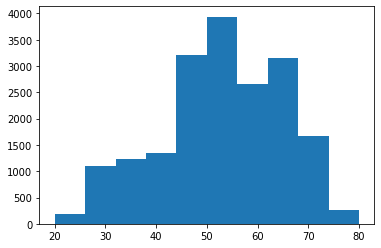

In [29]:
import matplotlib.pyplot as plt
plt.hist(X['buildUpPlaySpeed_x'],bins=10)

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
X_new_itr = imp.fit_transform(X[sub])
X[sub] = X_new_itr
X_train, X_test, y_train, y_test = train_test_split(X_new_itr,y, test_size=0.2,random_state=0)

In [23]:
pd.DataFrame(X_new_itr).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,74.296332,-1.0,-1.0,84.309151,-1.0,-1.0,55.319302,-1.0,58.829467,-1.0,51.892762,-1.0,-1.0,16.724865,-1.0,35.960234,-1.0,7.614766,-1.0,-1.0,74.318394,-1.0,-1.0,84.329752,-1.0,-1.0,55.373349,-1.0,58.842175,-1.0,51.88681,-1.0,-1.0,16.784418,-1.0,35.97388,-1.0,7.687852,-1.0,-1.0
1,74.296332,-1.0,-1.0,84.309151,-1.0,-1.0,55.319302,-1.0,58.829467,-1.0,51.892762,-1.0,-1.0,16.724865,-1.0,35.960234,-1.0,7.614766,-1.0,-1.0,74.318394,-1.0,-1.0,84.329752,-1.0,-1.0,55.373349,-1.0,58.842175,-1.0,51.88681,-1.0,-1.0,16.784418,-1.0,35.97388,-1.0,7.687852,-1.0,-1.0
2,74.296332,-1.0,-1.0,84.309151,-1.0,-1.0,55.319302,-1.0,58.829467,-1.0,51.892762,-1.0,-1.0,16.724865,-1.0,35.960234,-1.0,7.614766,-1.0,-1.0,74.318394,-1.0,-1.0,84.329752,-1.0,-1.0,55.373349,-1.0,58.842175,-1.0,51.88681,-1.0,-1.0,16.784418,-1.0,35.97388,-1.0,7.687852,-1.0,-1.0
3,74.296332,-1.0,-1.0,84.309151,-1.0,-1.0,55.319302,-1.0,58.829467,-1.0,51.892762,-1.0,-1.0,16.724865,-1.0,35.960234,-1.0,7.614766,-1.0,-1.0,74.318394,-1.0,-1.0,84.329752,-1.0,-1.0,55.373349,-1.0,58.842175,-1.0,51.88681,-1.0,-1.0,16.784418,-1.0,35.97388,-1.0,7.687852,-1.0,-1.0
4,74.296332,-1.0,-1.0,84.309151,-1.0,-1.0,55.319302,-1.0,58.829467,-1.0,51.892762,-1.0,-1.0,16.724865,-1.0,35.960234,-1.0,7.614766,-1.0,-1.0,74.318394,-1.0,-1.0,84.329752,-1.0,-1.0,55.373349,-1.0,58.842175,-1.0,51.88681,-1.0,-1.0,16.784418,-1.0,35.97388,-1.0,7.687852,-1.0,-1.0


(array([ 222., 1095., 1500., 1157., 4228., 3038., 2748., 3164., 8201.,
         626.]),
 array([20.        , 26.03706085, 32.07412169, 38.11118254, 44.14824338,
        50.18530423, 56.22236507, 62.25942592, 68.29648676, 74.33354761,
        80.37060845]),
 <BarContainer object of 10 artists>)

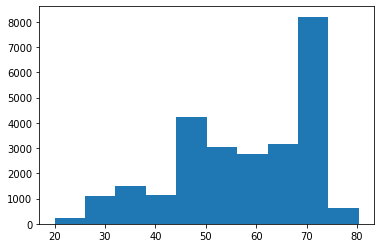

In [33]:
import matplotlib.pyplot as plt
plt.hist(X_new_itr[:,0],bins=10)

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=1)

model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy_score(y_pred,y_test)

## Simple Imputer

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_new_sim = imp.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new_sim,y, test_size=0.2,random_state=0)

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=10, n_estimators=100, n_jobs=32,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=1)

model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy_score(y_pred,y_test)

In [ ]:
# How many matches per league do we have?
# matches_df.groupby('country_id').size()
# matches_df[['season', 'home_team_api_id']].nunique(), team_attributes_df[['season_new', 'team_api_id']].nunique()
dict(matches_df.isna().sum())

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.85 * (1 - 0.85))
X_new = sel.fit_transform(X)

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest
X_new = SelectKBest(chi2, k=75).fit_transform(X_new, y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
feature_names = X.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

In [ ]:
importance = forest.feature_importances_
df = pd.DataFrame({'cols': X.columns, 'importance': importance}).sort_values(by='importance', ascending=False)
print(df.head(20))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
clf.feature_importances_


In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2,random_state=0)

In [ ]:
pd.DataFrame(X_new).head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=0)

print(model.fit(X_train,y_train))
y_temp = model.predict(X_train)
print(accuracy_score(y_train, y_temp))
y_pred = model.predict(X_test)

accuracy_score(y_pred,y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,10,15]
        }

model_xgb = XGBClassifier()
model_grid = GridSearchCV(model_xgb, params)


model_grid.fit(X_train,y_train)
model_grid.cv_results_
# y_pred = model_xgb.predict(X_test)
# accuracy_score(y_pred,y_test)

In [ ]:
matches_df.to_csv('matches.csv', index=False)

In [ ]:
!pip install xgboost

In [ ]:
y_tem = model_xgb.predict(X_train)
accuracy_score(y_train, y_tem)

In [ ]:
from sklearn.svm import SVC


model_svc = SVC()
param_svc = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             } 

model_grid_svm = GridSearchCV(model_svc,param_svc)
model_grid_svm.fit(X_train, y_train)
model_grid.cv_results_
# accuracy_score(model_svc.predict(X_test), y_test)